## Informer

In [1]:

#!pip install git+https://github.com/AtrCheema/AI4Water.git@e3ec95c560ff5f43a215a2339f6602980ba06f03
#!pip uninstall ai4water -y

In [2]:
import os

if "Informer2020" not in os.listdir():
    !git clone https://github.com/zhouhaoyi/Informer2020.git
else:
    print("folder already available")

folder already available


In [3]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']
    

In [4]:
sys.executable

'D:\\C\\Anaconda3\\envs\\informer_py38\\python.exe'

In [5]:
from typing import List, Union, Tuple

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd 

from SeqMetrics import RegressionMetrics

from easy_mpl import plot

from ai4water.postprocessing import ProcessPredictions 
from ai4water.utils import LossCurve
from ai4water.datasets import CAMELS_AUS
from ai4water.utils import TrainTestSplit
from ai4water.utils.utils import get_version_info
from ai4water.models._torch import Learner

for k,v in get_version_info().items():
    print(k, v)


**********Tensorflow models could not be imported **********

python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
os nt
ai4water 1.07
lightgbm 3.3.5
catboost 1.1.1
xgboost 1.7.5
easy_mpl 0.21.3
SeqMetrics 1.3.4
torch 1.8.0+cpu
numpy 1.24.3
pandas 1.5.3
matplotlib 3.7.1
h5py 3.8.0
sklearn 1.2.2
shapefile 2.3.1
xarray 2023.1.0
netCDF4 1.6.3
optuna 2.10.1
skopt 0.9.0
hyperopt 0.2.7
plotly 5.14.1
seaborn 0.12.2


D:\C\Anaconda3\envs\informer_py38\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [6]:
dataset = CAMELS_AUS(path="F:\\data\\CAMELS\\CAMELS_AUS")

In [62]:
df = dataset.fetch(
    stations='224214A',
    as_dataframe=True
)

df = df.unstack()

df = df['224214A']

df.columns.name = None

df.index.name = "date"

df = df.rename(columns={"streamflow_MLd": "y"})
df.columns

Index(['y', 'streamflow_MLd_inclInfilled', 'streamflow_mmd',
       'et_morton_actual_SILO', 'et_morton_point_SILO', 'et_morton_wet_SILO',
       'et_short_crop_SILO', 'et_tall_crop_SILO', 'evap_morton_lake_SILO',
       'evap_pan_SILO', 'evap_syn_SILO', 'precipitation_AWAP',
       'precipitation_SILO', 'precipitation_var_SWAP', 'solarrad_AWAP',
       'tmax_AWAP', 'tmin_AWAP', 'vprp_AWAP', 'mslp_SILO', 'radiation_SILO',
       'rh_tmax_SILO', 'rh_tmin_SILO', 'tmax_SILO', 'tmin_SILO',
       'vp_deficit_SILO', 'vp_SILO'],
      dtype='object')

In [63]:
columns = ['et_morton_actual_SILO', 'precipitation_SILO', 'radiation_SILO', 
                'vp_deficit_SILO', 'tmax_SILO', 'y']
df = df[columns]

df = df.loc["1975-01-01":]
df.isna().sum()

et_morton_actual_SILO     0
precipitation_SILO        0
radiation_SILO            0
vp_deficit_SILO           0
tmax_SILO                 0
y                        65
dtype: int64

In [64]:
df = df.fillna(method="ffill")
df.isna().sum()

et_morton_actual_SILO    0
precipitation_SILO       0
radiation_SILO           0
vp_deficit_SILO          0
tmax_SILO                0
y                        0
dtype: int64

In [65]:
df = df.reset_index()
df.head()

date  et_morton_actual_SILO  precipitation_SILO  radiation_SILO  \
0 1975-01-01               5.532793            0.578268       32.893409   
1 1975-01-02               4.356257            0.000000       32.047207   
2 1975-01-03               0.542570            0.000000       12.676816   
3 1975-01-04               1.980950            0.869162       15.442402   
4 1975-01-05               4.498603            0.000000       25.254190   

   vp_deficit_SILO  tmax_SILO        y  
0        16.314469  27.086146  129.120  
1        21.655028  29.811676  124.033  
2        17.663073  28.496313  119.666  
3        10.424134  22.622514  118.973  
4         7.716034  18.995922  117.164

<Axes: >

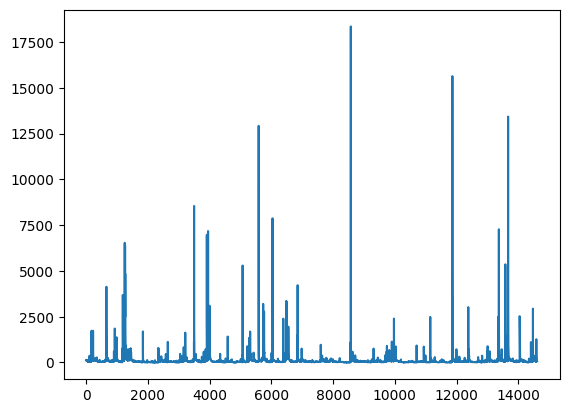

In [66]:
df['y'].plot()

In [67]:
tr_df, test_df, _, _ = TrainTestSplit().split_by_slicing(df)
tr_df.shape, test_df.shape

((10227, 7), (4383, 7))

In [68]:
from utils.tools import dotdict
from data.data_loader import Dataset_ETT_hour
from models.model import Informer
from utils.timefeatures import time_features
from utils.tools import StandardScaler

In [69]:
class Data(Dataset_ETT_hour):

    def _read_file(self, path):
        raise ValueError

    def __getitem__(self, index):
        s_begin = index  # 0
        s_end = s_begin + self.seq_len  # 96
        r_begin = s_end - self.label_len  # 48
        r_end = r_begin + self.label_len + self.pred_len  # 120

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        #return seq_x, seq_y, seq_x_mark, seq_y_mark
        return (seq_x, seq_x_mark, seq_y, seq_y_mark), seq_y


    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self._read_file(self.data_path)

        border1s = [0, 12*30*24 - self.seq_len, 12*30*24+4*30*24 - self.seq_len]  # [0, 8544, 11424]
        border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]  # [8640, 11520, 14400]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]  # (8640, 7)
        if self.inverse:
            self.data_y = df_data.values[border1:border2]  # (8640, 7)
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
        

class TrainData(Data):

    def _read_file(self, path):
        return tr_df

    
class TestData(Data):

    def _read_file(self, path):
        return test_df



In [70]:
pred_len = 1
label_len = 48
device = torch.device('cpu')
#device = torch.device('cpu:{}'.format(0))"
output_attention = False
inverse = False

In [71]:
tr_data_set = TrainData(
    root_path="",
    data_path="",
    flag='train',
    size=[96, label_len, pred_len],
    features="MS",
    target="OT",
    inverse=inverse,
    timeenc=1,
    # freq='D', # todo
    #cols=args.cols
)
#print(flag, len(data_set))
train_loader = DataLoader(
    tr_data_set,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    drop_last=True)


test_data_set = TestData(
    root_path="",
    data_path="",
    flag='train',
    size=[96, label_len, pred_len],
    features="MS",
    target="OT",
    inverse=inverse,
    timeenc=1,
    # freq='D', # todo
    #cols=args.cols
)
#print(flag, len(data_set))
test_loader = DataLoader(
    test_data_set,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    drop_last=True)

In [77]:
model = Informer(6, 
                 6, 
                 1, 
                 96, 
                 label_len=48, 
                 out_len=pred_len, 
                 d_model=64).float().to(device)
model = model.double()

In [78]:
import gc

class MyLearner(Learner):

    def eval(self, batch_x, batch_y):
        batch_x = batch_x if isinstance(batch_x, list) else [batch_x]

        #batch_x = [tensor.float() for tensor in batch_x]

        if self.use_cuda:
            batch_x = [tensor.cuda() for tensor in batch_x]
            batch_y = batch_y.cuda()

        pred_y = self.model(*batch_x)

        batch_y = batch_y[:, -pred_len:, -1:]

        batch_y = batch_y.squeeze()
        pred_y = pred_y.squeeze()

        return batch_y, pred_y

    def predict(
            self,
            x,
            y=None,
            batch_size: int = None,
            plots: List[str] = True,
            name: str = None,
            **kwargs
    ) -> np.ndarray:
        """Makes prediction on the given data

        Arguments:
            x : data on which to evalute. It can be

                - a torch.utils.data.Dataset
                - a torch.utils.data.DataLoader
                - a torch.Tensor
                - a numpy array
                - a list of torch tensors numpy arrays
            y : only relevent if `x` is torch.Tensor. It comprises labels for
                correspoing x.
            batch_size : None means make prediction on whole data in one go
            reg_plot : whether to plot regression line or not
            name : string to be used for title and name of saved plot

        Returns:
            predicted output as numpy array
        """
        true, pred = self._eval(x=x, y=y, batch_size=batch_size)

        if len(true)>1 and plots is not None and pred.size > 0.0:
            pp = ProcessPredictions(
                mode="regression",
                path=self.path,
                forecast_len=1,
                output_features=None,
                plots=plots,
                show=bool(self.verbosity),
            )
            pp(true, pred, model=self)

        #if self.use_cuda:
        torch.cuda.empty_cache()
        gc.collect()
        return pred

In [79]:
learner = MyLearner(model=model, #use_cuda=False, 
                    num_epochs=300,
                    to_monitor = ["nse"]
                   )

In [80]:
learner.loss = "mse" # torch.nn.MSELoss()
learner.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [81]:
h = learner.fit(train_loader, validation_data = test_loader)

*************************Training Started*************************
Epoch:  mse             nse             mse             nse            
**********************************************************************
0      0.9778000       -1.4075000      0.9538000       -2.3611000      
1      0.9372000       -1.2388000      1.0405000       -7.8936000      
2      0.9586000       -0.6228000      0.9724000       -1.0264000      
3      0.9006000       -1.1281000      1.0610000       -3.6077000      
4      0.9360000       -1.5363000      0.9792000       -0.3347000      
5      0.9256000       -0.7415000      0.9573000       -2.1978000      
6      0.8906000       -1.0815000      1.0012000       -4.5436000      
7      0.9210000       -0.9095000      0.9575000       -6.1965000      
8      0.9006000       -0.8719000      0.9468000       -11.7015000     
9      1.0061000       -0.5985000      1.0231000       -0.0715000      
10     0.9740000       -0.5144000      1.0599000       -8.0518000     

111    0.1244000       0.5013000       0.0853000       -0.0151000      
112    0.0757000       0.5100000       0.0680000       -0.2021000      
113    0.0572000       0.6693000       0.0488000       0.6222000       
114    0.0305000       0.7793000       0.0257000       0.7709000       
115    0.0307000       0.7811000       0.0245000       0.5612000       
116    0.0576000       0.6464000       0.4013000       -23.5799000     
117    0.2206000       -4.8280000      0.0889000       -1.3653000      
118    0.0776000       0.3452000       0.0342000       0.3323000       
119    0.0446000       0.6591000       0.0381000       0.3415000       
120    0.0560000       0.6653000       0.0374000       0.2404000       
121    0.0390000       0.6807000       0.0351000       -0.0195000      
122    0.0359000       0.6948000       0.0952000       -0.1663000      
123    0.0918000       0.5293000       0.0519000       -0.3836000      
124    0.0536000       0.6260000       0.1066000       0.3598000

225    0.0492000       0.8016000       0.0451000       0.5372000       
226    0.0237000       0.8233000       0.0413000       0.5110000       
227    0.0995000       0.5929000       0.0428000       0.5923000       
228    0.0898000       0.3775000       0.0342000       0.2566000       
229    0.0457000       0.7047000       0.0343000       0.5558000       
230    0.0278000       0.7848000       0.0664000       0.6701000       
231    0.0268000       0.8506000       0.0390000       0.5077000       
232    0.0475000       0.7180000       0.0298000       0.1282000       
233    0.0514000       0.6818000       0.0622000       -0.1741000      
234    0.0506000       0.7013000       0.0859000       -0.0812000      
235    0.0262000       0.7836000       0.0467000       0.7890000       
236    0.0347000       0.8106000       0.0440000       0.2358000       
237    0.0236000       0.8299000       0.0150000       0.7573000       
238    0.0474000       0.7285000       0.0398000       0.5331000

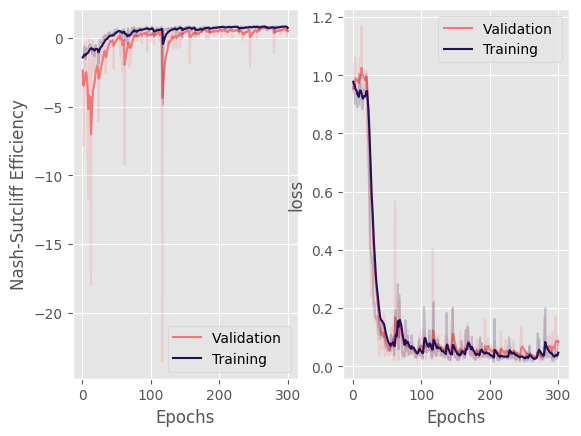

<Axes: xlabel='Epochs', ylabel='loss'>

In [82]:
LossCurve().plot(h.history, smoothing="ewma")

In [94]:
learner.evaluate(test_loader, metrics=["nse", "kge", "kge_np"])

TypeError: evaluate() missing 1 required positional argument: 'y'

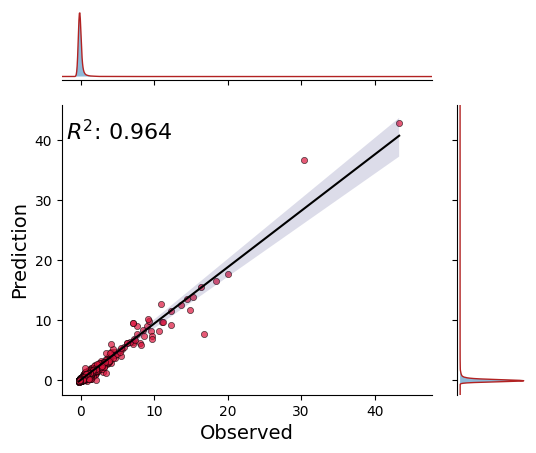

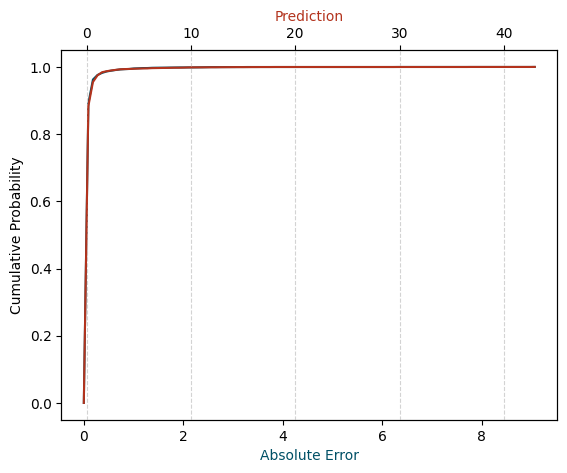

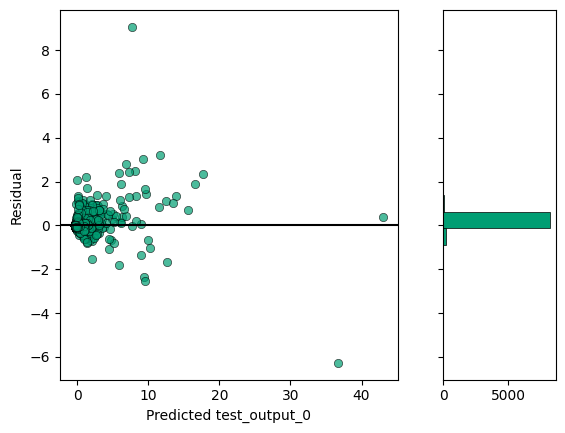

In [85]:
p = learner.predict(train_loader, plots=["regression", "edf", "residual"])

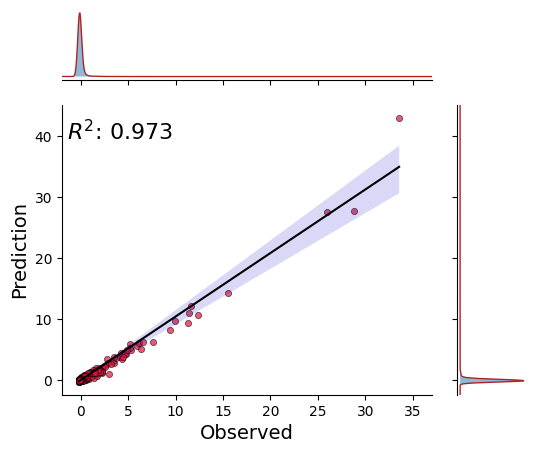

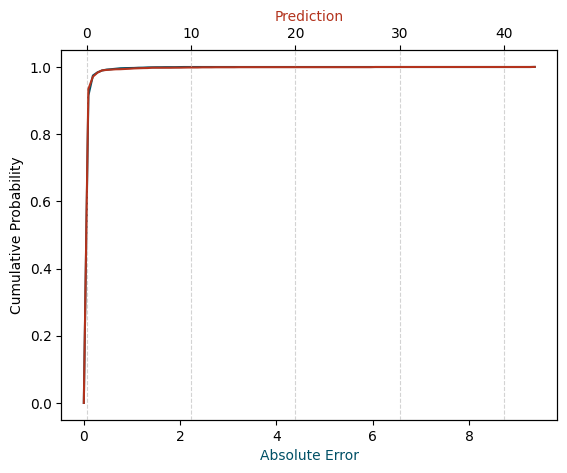

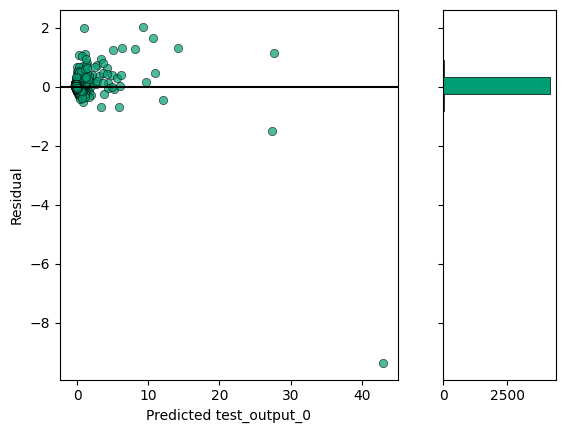

In [83]:
p = learner.predict(test_loader, plots=["regression", "edf", "residual"])

In [87]:
device

device(type='cpu')

In [93]:
# attention visualization
idx = 0
for i, ((batch_x,batch_y,batch_x_mark,batch_y_mark), batch_y) in enumerate(test_loader):
    if i!=idx:
        continue
    batch_x = batch_x.to(device)
    batch_y = batch_y

    batch_x_mark = batch_x_mark.to(device)
    batch_y_mark = batch_y_mark.to(device)
    
    dec_inp = torch.zeros_like(batch_y[:,-pred_len:,:])
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).to(device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) 

IndexError: index out of range in self